In [43]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Hourly
import meteostat
import requests
import json
import warnings

from sys import platform

if platform == "win32":
    path = 'C:/Users/olive/GitHub/f1-analytics/'
elif platform == "darwin":
    path = '/Users/oliverjcarter/Documents/GitHub/f1-analytics/'

warnings.filterwarnings("ignore", category=RuntimeWarning) 
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [44]:
races = pd.read_csv(path+'data/races.csv')

weather = races.iloc[:,[0,1,2,3,4,5,6]]
weather.shape

(160, 7)

In [45]:
### Just analyzing Spa 2021 as the weather was so bad the race was canelled.

s2021 = weather.query('season == 2021 & round == 12')

race = s2021.iloc[0]

race

season              2021
round                 12
circuit_id           spa
country          Belgium
lat              50.4372
long             5.97139
date          2021-08-29
Name: 149, dtype: object

4.0


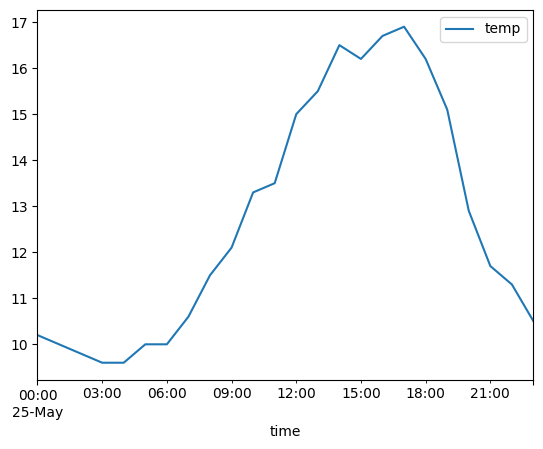

In [79]:
# start = datetime.strptime(race.date, '%Y-%m-%d')
# end = datetime.strptime(race.date, '%Y-%m-%d')
start = datetime(2020,5,25)
end = datetime(2020,5,25,23)
coord = Point(race.lat, race.long)

data = Hourly(coord, start, end).fetch()

data.plot(y=['temp'])
print(data.coco.mode()[0])
plt.show()